#### *Run this cell to resolve import issues*

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Imports and variables

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
%matplotlib inline
import matplotlib.pyplot as plt
from statistics import NormalDist

from numpy_ringbuffer import RingBuffer
import pathlib

from log_parser import parse_keyboard_log

# Size of sliding window for each key 
# (mean and stddev of the last {sample_size} key taps)
sample_size = 20

# Amount of data to record before overwriting old data
data_window_limit = 100

# Amount of profile training data to record before overwriting old data
profile_data_limit = 1000

# Read logfile paths from .routing
log_paths = None

#### Data persistence functions

In [3]:
# Load data from saved profile and return a tuple of dicts
def load_tap_profile (profile):
    mean_data = {}  # Dict to store mean data
    std_data  = {}  # Dict to store stddev data
    key_data  = []  # List to store all raw data associated with a key

    with open(f"profiles/{profile}.tap", 'r', encoding='utf-8') as f:
        lines = f.read().splitlines() # Read lines without '\n's
        # Group data 2 rows at a time (each key has 2 lines of data)
        for i in range(0, len(lines), 2): 
            key_data.append((lines[i], lines[i + 1]))
        # Iterate through each key's raw data
        for key_mean, key_std in key_data:
            # Separate values by commas
            key_mean = key_mean.split(',')
            key_std  = key_std.split(',')
            key = key_mean[0] # First value is always the key
            # Initialize ring buffers
            mean_data[key] = RingBuffer(profile_data_limit) 
            std_data[key]  = RingBuffer(profile_data_limit)
            # Append mean values to ring buffer
            for value in key_mean[2:]:
                mean_data[key].append(value)
            # Append stddev values to ring buffer
            for value in key_std[2:]:
                std_data[key].append(value)
    
    return (mean_data, std_data)

# Save data to file in profiles directory
def save_session_tap_data(profile, mean_data, std_data):
    # Expected that both dicts have similar keys
    keys = list(mean_data.keys()) # List keys that have data associated with them
    mean_profile, std_profile = mean_data, std_data # Default profile data

    # Add to the profile if it already exists
    if pathlib.Path(f"profiles/{profile}.tap").exists():
        mean_profile, std_profile = load_tap_profile(profile) # Load current profile
        # Iterate through keys and update the profile for each one
        for key in keys: 
            mean_np = np.array(mean_data[key]) # Convert arg to numpy array
            std_np  = np.array( std_data[key]) # Convert arg to numpy array
            # Append contents of each key ring buffer to loaded buffers
            for value in mean_np:
                # Check that key has data already
                if key not in mean_profile.keys():
                    # If no, create new ring buffer first
                    mean_profile[key] = RingBuffer(profile_data_limit)
                mean_profile[key].append(value) # Append new value to data
            # Same deal as above but with standard deviations
            for value in std_np:
                # Check that key has data already
                if key not in std_profile.keys():
                    # If no, create new ring buffer first
                    std_profile[key] = RingBuffer(profile_data_limit)
                std_profile[key].append(value) # Append new value to data

    # Save the combined data back to file
    with open(f"profiles/{profile}.tap", 'w', encoding='utf-8') as f:    
        for key in keys: # For each key
            mean_values = list(mean_profile[key])  # List mean values
            std_values  = list(std_profile[key])   # List stddev values
            # Write mean values (key,number of values, values...)
            f.write(str(key) + ',' + str(mean_profile[key].shape[0]) + ',')
            f.write(','.join(format(x, "0.4f") for x in mean_values))
            f.write('\n')
            # Write stddev values (key,number of values, values...)
            f.write(str(key) + ',' + str(std_profile[key].shape[0]) + ',')
            f.write(','.join(format(x, "0.4f") for x in std_values))
            f.write('\n')

### Gather key tap duration data from log files
Records all quick presses ("taps") of keys, calculates the mean and stddev of the last
{sample_size} taps, then stores the data in a larger sliding window of size {data_window_size}.

*Currently the last 20 taps are analyzed and the last 100 samples are used to train the user's profile.*

---

In [9]:
def get_session_data(filepath):

    # Make sure it's a keylog
    if "key.log" not in filepath: return (None, None, None)
    
    profile = filepath.split('/')[2]          # Use 3 letter profile name
    kb = parse_keyboard_log("../" + filepath) # Convert keylog to DataFrame

    duration_dict = {} # Map each key to a ring buffer of size {sample_size}
    presstimes    = {} # Record the 'last pressed' time of each key
    mean          = {} # Records the mean of each key sample window
    stddev        = {} # Records the stddev of each key sample window
    
    for _, row in kb.iterrows():    # Analyze each piece of data one at a time
        key = str(row.key).replace('\'', '') # Get rid of ' characters

        if key not in duration_dict.keys():   # If key not added to dict yet
            duration_dict[key] = RingBuffer(sample_size) # Add it
        
        if row.action == 'pressed':     # If key was pressed
            presstimes[key] = row.time  # Record time of press
        
        # If key was released and it has been pressed before
        elif row.action == 'released' and key in presstimes.keys():
            duration = row.time - presstimes[key] # Calculate press duration

            if duration < 0.4: # Only append key taps (<0.4s)
                duration_dict[key].append(duration) # Append tap duration to ring buffer

                durations_np = np.array(duration_dict[key]) # Convert to numpy array
                if durations_np.size > 3:      # If more than 3 samples in the ring buffer
                    
                    if key not in mean.keys(): # If key not added to mean/stddev dicts yet
                        mean[key]   = RingBuffer(data_window_limit) # Add them
                        stddev[key] = RingBuffer(data_window_limit)

                    # Record mean/stddev of sample in both dicts
                    mean[key].append(durations_np.mean())
                    stddev[key].append(durations_np.std())
    
    # Return a tuple of gathered information
    return (profile, mean, stddev)


# Read logfile paths from .routing
log_paths = None
with open("../.routing", 'r', encoding='utf-8') as f:
    log_paths = f.read().splitlines()   # Read lines without '\n's

log_paths = [
    "./logs/JON/SOL/key.log",
    "./logs/JON/PYR/key.log",
    "./logs/JON/SPY/key.log",
    "./logs/MIT/SOL/key.log",
    "./logs/MIT/SNI/key.log",
    "./logs/MIT/SCO/key.log",
    "./logs/HEN/SOL/key.log",
    "./logs/HEN/SNI/key.log",
    "./logs/HEN/DEM/key.log",
    "./logs/MAR/SNI/key.log",
    "./logs/MAR/DEM/key.log",
    "./logs/ZIR/SOL/key.log",
    "./logs/ZIR/SNI/key.log",
    "./logs/ZIR/PYR/key.log",
    "./logs/JOS/SOL/key.log",
    "./logs/JOS/SNI/key.log"
]

for log_path in log_paths: # For each log file
    # Gather session key tap data
    profile, means, stds = get_session_data(log_path)
    # Write data to file
    save_session_tap_data(profile, means, stds)


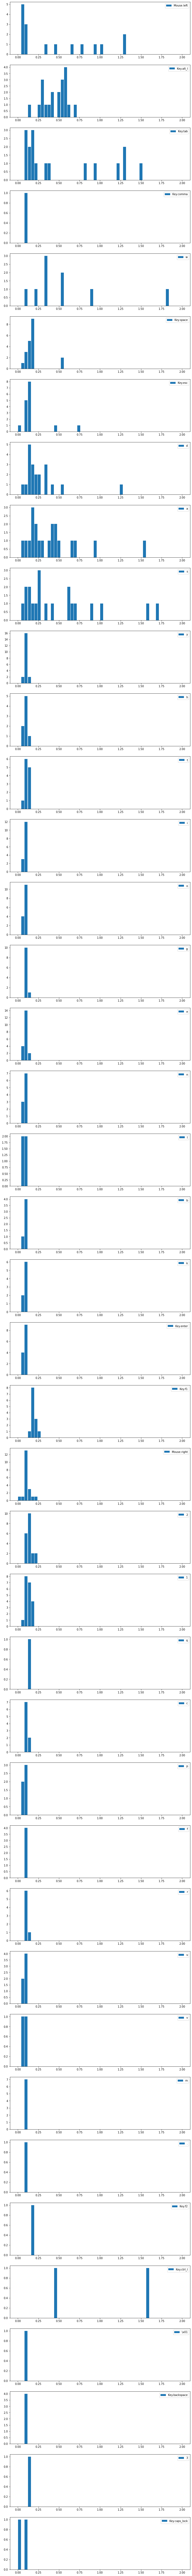

In [16]:
def plot_something(filepath):
    
    kb = parse_keyboard_log("../" + filepath) # Convert keylog to DataFrame

    duration_dict = {} # Map each key to a ring buffer of size {sample_size}
    presstimes    = {} # Record the 'last pressed' time of each key
    
    for _, row in kb.iterrows():    # Analyze each piece of data one at a time
        key = str(row.key).replace('\'', '') # Get rid of ' characters

        if key not in duration_dict.keys():   # If key not added to dict yet
            duration_dict[key] = RingBuffer(sample_size) # Add it
        
        if row.action == 'pressed':     # If key was pressed
            presstimes[key] = row.time  # Record time of press
        
        # If key was released and it has been pressed before
        elif row.action == 'released' and key in presstimes.keys():
            duration = row.time - presstimes[key] # Calculate press duration
            duration_dict[key].append(duration) # Append tap duration to ring buffer
    
    keys = list(duration_dict.keys())
    _, ax = plt.subplots(len(keys), figsize=(12, 175))
    for i, key in enumerate(keys):
        ax[i].hist(duration_dict[key], bins=50, rwidth=0.9, range=(0, 2), label=str(key))
        ax[i].legend()


# Read logfile paths from .routing
log_paths = None
with open("../.routing", 'r', encoding='utf-8') as f:
    log_paths = f.read().splitlines()   # Read lines without '\n's

plot_something(log_paths[3])

# for log_path in log_paths: # For each log file
#     # Skip mouse logs
#     if "key.log" not in log_path: continue
#     # Plot histogram
#     plot_something(log_path)



### Verify session
Take the current play session's recorded key tap information and compare it against
the players profile built from previous verified sessions. 

Output a confidence value

In [5]:
# Just some helper functions
def plot_normals(mean1, std1, mean2, std2, ax, label):
    x1 = np.linspace(mean1 - 3*std1, mean1 + 3*std1, 100)
    x2 = np.linspace(mean2 - 3*std2, mean2 + 3*std2, 100)
    ax.set_title(label)
    ax.plot(x1, stats.norm.pdf(x1, mean1, std1))
    ax.plot(x2, stats.norm.pdf(x2, mean2, std2))

def clamp(n, smallest, largest): 
    return max(smallest, min(n, largest))

In [6]:
def verify_session(session_mean_data, session_std_data, profile, plotting=False):
    # Load user's profile
    profile_mean_data, profile_std_data = load_tap_profile(profile)

    # Test only for keys that exist in both records
    shared_keys = set(session_mean_data.keys()).intersection(set(profile_mean_data.keys()))

    # Calculate mean and stdev of each key's mean and stdev (so meta)
    # Means in profile
    profile_mean_overall_mean, profile_mean_overall_std = {}, {}
    for key in list(profile_mean_data.keys()):
        profile_mean_overall_mean[key] = np.array(profile_mean_data[key]).mean()
        profile_mean_overall_std[key]  = np.array(profile_mean_data[key]).std()
    # Means in session
    session_mean_overall_mean, session_mean_overall_std = {}, {}
    for key in list(session_mean_data.keys()):
        session_mean_overall_mean[key] = np.array(session_mean_data[key]).mean()
        session_mean_overall_std[key]  = np.array(session_mean_data[key]).std()

    # Standard deviations in profile
    profile_std_overall_mean, profile_std_overall_std = {}, {}
    for key in list(profile_std_data.keys()):
        profile_std_overall_mean[key] = np.array(profile_std_data[key]).mean()
        profile_std_overall_std[key]  = np.array(profile_std_data[key]).std()
    # Standard deviations in session
    session_std_overall_mean, session_std_overall_std = {}, {}
    for key in list(session_mean_data.keys()):
        session_std_overall_mean[key] = np.array(session_std_data[key]).mean()
        session_std_overall_std[key]  = np.array(session_std_data[key]).std()

    scores = []
    for key in shared_keys:
        weight = min(np.array(session_mean_data[key]).size, np.array(profile_mean_data[key]).size)

        session_mean_dist = NormalDist(session_mean_overall_mean[key], session_mean_overall_std[key])
        session_std_dist  = NormalDist(session_std_overall_mean[key], session_std_overall_std[key])
        profile_mean_dist = NormalDist(profile_mean_overall_mean[key], profile_mean_overall_std[key])
        profile_std_dist  = NormalDist(profile_std_overall_mean[key], profile_std_overall_std[key])

        if (session_mean_dist.stdev == 0) or (session_std_dist.stdev == 0) or \
           (profile_mean_dist.stdev == 0) or (profile_std_dist.stdev == 0):
            continue

        means_overlap = session_mean_dist.overlap(profile_mean_dist)
        stdev_overlap = session_std_dist.overlap(profile_std_dist)

        if plotting:
            _, ax = plt.subplots(1, 2, figsize=(14, 5))
            plot_normals(session_mean_dist.mean, session_mean_dist.stdev,
                profile_mean_dist.mean, profile_mean_dist.stdev, ax[0], f"{key} means\n{means_overlap:.4f}")
            plot_normals(session_std_dist.mean, session_std_dist.stdev,
                profile_std_dist.mean, profile_std_dist.stdev, ax[1], f"{key} stds\n{stdev_overlap:.4f}")

        # Lazy weighted average
        # Appends each score once for each sample used to create the distribution
        # So some scores get appended 100 times
        for _ in range(weight):
            scores.append(means_overlap)
            scores.append(stdev_overlap)

    weighted_avg_score = np.mean(scores)

    # And we don't need to discuss whats going on here
    # But basically it's just adjusting the score to fit in the [0, 1] range
    modified_score = weighted_avg_score * 1.75 - 0.5
    confidence = clamp(modified_score, 0, 1)
    return confidence
    

In [13]:
profile = "JON"
session = "MARSOL"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")

Verifying MARSOL session against JON profile...
46.59%


In [13]:
print("---- Comparing similar profiles ----")
profile = "HEN"
session = "HENSOL"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")

profile = "HEN"
session = "HENSNI"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")

profile = "HEN"
session = "HENDEM"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")


print('')
profile = "JON"
session = "JONSOL"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")

profile = "JON"
session = "JONPYR"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")

profile = "JON"
session = "JONSPY"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")


print('')
profile = "MAR"
session = "MARSOL"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")

profile = "MAR"
session = "MARSNI"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")

profile = "MAR"
session = "MARDEM"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")


print('')
profile = "MIT"
session = "MITSOL"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")

profile = "MIT"
session = "MITSNI"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")

profile = "MIT"
session = "MITSCO"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")


print('')
profile = "ZIR"
session = "ZIRSOL"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")

profile = "ZIR"
session = "ZIRSNI"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")

profile = "ZIR"
session = "ZIRPYR"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")


print("\n---- Comparing different players ----")
profile = "HEN"
session = "JOSSNI"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")

profile = "JON"
session = "JOSSNI"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")

profile = "MAR"
session = "JOSSNI"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")

profile = "MIT"
session = "JOSSNI"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")

profile = "ZIR"
session = "JOSSNI"
_, session_means, session_stds = get_session_data(f"logs/{session[:3]}/{session[3:]}/key.log")
print(f"Verifying {session} session against {profile} profile...")
verification = verify_session(session_means, session_stds, profile)
print(f"{(verification*100):.2f}%")


---- Comparing similar profiles ----
Verifying HENSOL session against HEN profile...
80.78%
Verifying HENSNI session against HEN profile...
92.21%
Verifying HENDEM session against HEN profile...
87.29%

Verifying JONSOL session against JON profile...
68.72%
Verifying JONPYR session against JON profile...
90.73%
Verifying JONSPY session against JON profile...
79.53%

Verifying MARSOL session against MAR profile...
66.23%
Verifying MARSNI session against MAR profile...
67.10%
Verifying MARDEM session against MAR profile...
82.21%

Verifying MITSOL session against MIT profile...
87.85%
Verifying MITSNI session against MIT profile...
84.49%
Verifying MITSCO session against MIT profile...
88.93%

Verifying ZIRSOL session against ZIR profile...
69.80%
Verifying ZIRSNI session against ZIR profile...
62.42%
Verifying ZIRPYR session against ZIR profile...
70.27%

---- Comparing different players ----
Verifying JOSSNI session against HEN profile...
35.60%
Verifying JOSSNI session against JON pro